# GPU Info

In [1]:
!nvidia-smi

Thu Mar 13 17:41:47 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 960M        Off |   00000000:01:00.0 Off |                  N/A |
| N/A   35C    P8             N/A /  200W |       5MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Installations

In [2]:
# !pip3 install torch torchvision torchaudio matplotlib pandas numpy torchmetrics tqdm --break-system-packages

# Imports

In [341]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader,random_split
from torch.optim import Adam, SGD, Adamax, RMSprop, AdamW, lr_scheduler

import torchvision
import torchvision.transforms as T
from torchvision.transforms import functional as TF
from torchvision.utils import make_grid

from monai.networks.nets import UNet

from PIL import Image

from tqdm import tqdm
from torchmetrics.classification import Dice

import matplotlib.pyplot as plt

from os import listdir, system, getcwd
import re
from datetime import datetime
from typing import Callable

In [4]:
torch.__version__, torchvision.__version__

('2.5.1+cu121', '0.20.1+cu121')

# Functions and Classes

In [5]:
def num_parameters(model):
    params = sum([p.numel() for p in model.parameters()])
    
    return f"Number of Parameters: {params:,}"

In [6]:
class WeightedDiceLoss2(nn.Module):
    def __init__(self, weight_tumor=1.632, weight_background=1.0, smooth=1e-6):
        super(WeightedDiceLoss2, self).__init__()
        self.weights = torch.tensor([weight_background, weight_tumor]).to(device)  # Adjust weights
        self.smooth = smooth

    def forward(self, preds, targets):
        preds = torch.sigmoid(preds).float()
        targets = targets.float()
        
        # Flatten
        preds = preds.flatten(1)
        targets = targets.flatten(1)
        
        # Weighted intersection and union
        intersection = (preds * targets * self.weights[1] + (1 - preds) * (1 - targets) * self.weights[0]).sum(dim=1)
        total = preds.sum(dim=1) + targets.sum(dim=1)
        
        dice = (2. * intersection + self.smooth) / (total + self.smooth)
        
        return 1. - dice.mean()

In [7]:
class WeightedDiceLoss(nn.Module):
    def __init__(self, weight=1.632, smooth=1e-6):
        super().__init__()
        self.weight = weight
        self.smooth = smooth
    
    def forward(self, pred, target):
        assert pred.size() == target.size()

        pred = torch.sigmoid(pred)
        
        pred = pred.flatten(1)
        target = target.flatten(1)
        
        intersection = (pred * target).sum(dim=1)
        total = pred.sum(dim=1) + target.sum(dim=1)
    
        weights = torch.where(torch.max(target) == 1, self.weight, 1.).to(device)
        dice_coef = (2. * intersection + self.smooth) / (total + self.smooth)
        weighted_dice_coef = weights * dice_coef

        dice_loss = 1 - weighted_dice_coef

        return dice_loss.mean()

In [8]:
class DiceLoss(nn.Module):

    def __init__(self):
        super(DiceLoss, self).__init__()
        self.smooth = 1e-7

    def forward(self, y_pred, y_true):
        assert y_pred.size() == y_true.size()
        
        y_pred = torch.sigmoid(y_pred)
        
        y_pred = y_pred[:, 0].contiguous().view(-1)
        y_true = y_true[:, 0].contiguous().view(-1)
        
        intersection = (y_pred * y_true).sum()
        dsc = (2. * intersection + self.smooth) / (y_pred.sum() + y_true.sum() + self.smooth)
        
        return 1. - dsc

In [9]:
class Averaging():
    def __init__(self):
        self.sum = 0.
        self.counter = 0

    def __call__(self, val: float) -> float:
        self.sum += val
        self.counter += 1

    def compute(self):
        return self.sum / self.counter

    def reset(self):
        self.sum = 0.
        self.counter = 0

In [10]:
def train_one_epoch(model, dataloader, optimizer, loss_fn, avg_fn, ep, device):
    model.train()
    avg_fn.reset()

    with tqdm(dataloader, desc=f"Epoch {ep}", unit=" batch") as trange:
        for x_batch, y_batch in trange:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            # Forward
            yp = model(x_batch)
            loss = loss_fn(yp, y_batch)

            # Backward
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # Calculate the average of Dice Loss
            avg_fn(loss.item())
            avg_loss = avg_fn.compute()
            
            trange.set_postfix(Dice_loss=avg_loss)

    return model, avg_loss

In [11]:
def validate_one_epoch(model, dataloader, loss_fn, avg_fn, device):
    model.eval()
    avg_fn.reset()

    print("Plase Wait! Validation is being calculated", end='\r')

    with torch.no_grad():
        for x_batch, y_batch in dataloader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
    
            # Forward
            yp = model(x_batch)
            loss = loss_fn(yp, y_batch)
    
            # Calculate the average of Dice Loss
            avg_fn(loss.item())
            avg_loss = avg_fn.compute()

    print(f"Valid => Dice_loss: {avg_loss:.3}".ljust(55))
    
    return avg_loss

In [12]:
def plot_histories(train_loss_hist, train_acc_hist, valid_loss_hist, valid_acc_hist):
    plt.title("Learning Curve")

    plt.plot(train_loss_hist, c='b', label="Train Loss")
    plt.plot(valid_loss_hist, c='r', label="Valid Loss")
    
    plt.ylabel("Weighted Dice Loss")
    plt.xlabel("Epoch")
    
    plt.grid()
    plt.legend()

# Device and Inits

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [14]:
segment_loss_fn = DiceLoss().to(device)
weighted_dice_loss = WeightedDiceLoss().to(device)
# weighted_dice_loss = WeightedDiceLoss2().to(device)
avg_fn = Averaging()

# Custom Dataset <a href="https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset">Download Dataset</a>

## First Dataset

In [263]:
class MRIDataset(Dataset):
    def __init__(self, probability_transforms, dir_path=f"{getcwd()}/kaggle_3m"):
        
        self.probability_transforms = probability_transforms
        self.binary_threshold = 0.3
        self.image_pattern = r".tif"
        self.mask_pattern = r"_mask"
        self.images_ls = []
        self.masks_ls = []
        self.labels = []

        self.to_tensor_transform = T.ToTensor()
        self.normalize_transform_1d = T.Normalize(mean=0, std=1)
        self.normalize_transform_3d = T.Normalize(mean=[0, 0, 0], std=[1, 1, 1])

        patients_path = listdir(dir_path)
        
        patients_path.remove("data.csv")
        patients_path.remove("README.md")
        # patients_path.remove(".ipynb_checkpoints")

        for patient in patients_path:
            patient_images = listdir(f"{dir_path}/{patient}/")
            patient_images.sort(key=lambda x:x.replace(self.mask_pattern, ""))
            
            for img_path in patient_images:
                if re.search(self.image_pattern, img_path) is None:
                    continue
                
                if re.search(self.mask_pattern, img_path) is None:
                    self.images_ls.append(f"{dir_path}/{patient}/{img_path}")
                else:
                    mask_addr = f"{dir_path}/{patient}/{img_path}"
                    self.masks_ls.append(mask_addr)
                    pil_mask = Image.open(mask_addr)
                    self.labels.append(1 if torch.max(self.to_tensor_transform(pil_mask)) > 0 else 0)
        self.aa()

    def __getitem__(self, item_idx):

        # Open image and relevant mask from their address
        pil_img = Image.open(self.images_ls[item_idx])
        pil_mask = Image.open(self.masks_ls[item_idx])

        # Put probabiliy transforms on image and its mask
        transformed_img = self.probability_transforms(pil_img)
        transformed_mask = self.probability_transforms(pil_mask)

        # Make the image and mask tensor
        transformed_img = self.to_tensor_transform(transformed_img)
        transformed_mask = self.to_tensor_transform(transformed_mask)
        
        # Normalize them based on their channels
        transformed_img = self.normalize_transform_3d(transformed_img)
        transformed_mask = self.normalize_transform_1d(transformed_mask)

        # Make the mask binary (Conver to Black and White)
        transformed_mask = (transformed_mask > self.binary_threshold).float()

        # return transformed_img, transformed_mask, self.labels[item_idx]
        return transformed_img, transformed_mask
    
    def raw_item(self, item_idx):
        img = Image.open(self.images_ls[item_idx])
        mask = Image.open(self.masks_ls[item_idx])
        
        return self.to_tensor_transform(img), self.to_tensor_transform(mask), self.labels[item_idx]

    # TODO: Check the final result for each sample based on the generated mask.
    def check_result(self):
        pass

    def aa(self):
        i = 0
        lab = self.labels
        
        for idx, l in enumerate(lab):
            if l == 0 and i < 869:
                self.images_ls.pop(idx)
                self.masks_ls.pop(idx)
                self.labels.pop(idx)
                i += 1

    
    def __len__(self):
        return len(self.images_ls)

## Second Dataset

In [388]:
class MD(Dataset):
    def __init__(self, phase="train", dir_path=f"{getcwd()}/kaggle_3m_cleaned", transforms=None):
        assert phase in ["train", "valid", "test"]
        self.phase = phase
        self.dir_path = dir_path
        self.train_addr, self.valid_addr, self.test_addr = samples_addr()
        
    def samples_addr():
               
        image_pattern = r".tif"
        mask_pattern = r"_mask"
        samples = []
    
        patients_path = listdir(dir_path)
        
        patients_path.remove("data.csv")
        patients_path.remove("README.md")
        # patients_path.remove(".ipynb_checkpoints")
    
        for patient in patients_path:
            patient_images = listdir(f"{dir_path}/{patient}/")
            patient_images.sort(key=lambda x:x.replace(mask_pattern, ""))
    
            for sample_idx in range(0, len(patient_images), 2):
                if re.search(image_pattern, patient_images[sample_idx]) is None:
                    continue
    
                main_addr = f"{dir_path}/{patient}"
                
                if "mask" in f"{main_addr}/{patient_images[sample_idx]}":
                    samples.append((f"{main_addr}/{patient_images[sample_idx+1]}", f"{main_addr}/{patient_images[sample_idx]}"))
                    continue
                    
                samples.append((f"{main_addr}/{patient_images[sample_idx]}", f"{main_addr}/{patient_images[sample_idx+1]}"))
        
        torch.manual_seed(22)
        train, valid, test = random_split(samples, [0.7, 0.2, 0.1])
    
        return train, valid, test
    
    def read_item(self, _set, item_idx):
        img = Image.open(_set[item_idx][0])
        msk = Image.open(_set[item_idx][1])

        # if self.phase == "train":
        #     trans_1 = T.RandomApply([T.RandomRotation(30), T.ColorJitter(1, 2, 3)], p=0.4)
        #     img = trans_1(img)
        #     msk = trans_1(msk)

        img = TF.to_tensor(img)
        msk = TF.to_tensor(msk)
        
        # img = TF.normalize(img, mean=(0, 0, 0), std=(1, 1, 1))
        # msk = TF.normalize(msk, mean=0, std=1)
        
        return img, msk
    
    def __getitem__(self, item_idx):
        if self.phase == "train":
            return self.read_item(self.train_addr, item_idx)
        elif self.phase == "valid":
            return self.read_item(self.valid_addr, item_idx)
        elif self.phase == "test":
            return self.read_item(self.test_addr, item_idx)
    
    def __len__(self):
        if self.phase == "train":
            return len(self.train_addr)
        elif self.phase == "valid":
            return len(self.valid_addr)
        elif self.phase == "test":
            return len(self.test_addr)

# Preprocessing

## Transforms

In [16]:
probability_transforms = T.Compose([
    # T.RandomHorizontalFlip(),
    # T.RandomRotation(60),
    # T.AutoAugment(),
    # T.ElasticTransform()
])

## Read datasets (Train, Valid, Test)

In [389]:
train_set = MD(phase="train")
img = train_set[0][0]
train_set.__len__(), img.shape, img.dtype, img.min(), img.max()

(2531, torch.Size([3, 256, 256]), torch.float32, tensor(0.), tensor(1.))

In [413]:
a = []

for i in train_set:
    a.append(i[0])

In [411]:
torch.mean(train_set[0][0], dim=0)

tensor([[0.0013, 0.0013, 0.0013,  ..., 0.0026, 0.0026, 0.0000],
        [0.0039, 0.0065, 0.0078,  ..., 0.0078, 0.0078, 0.0026],
        [0.0039, 0.0092, 0.0118,  ..., 0.0065, 0.0092, 0.0026],
        ...,
        [0.0000, 0.0092, 0.0026,  ..., 0.0105, 0.0013, 0.0065],
        [0.0000, 0.0092, 0.0065,  ..., 0.0092, 0.0078, 0.0026],
        [0.0000, 0.0065, 0.0065,  ..., 0.0013, 0.0026, 0.0026]])

In [390]:
valid_set = MD(phase="valid")
valid_set.__len__()

723

In [391]:
test_set = MD(phase="test")
test_set.__len__()

361

## Visualize Random 6 Samples with Their Labels

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.011764706..1.5450981].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.019607844..1.3058823].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.3764706].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.2627451].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.6235294].


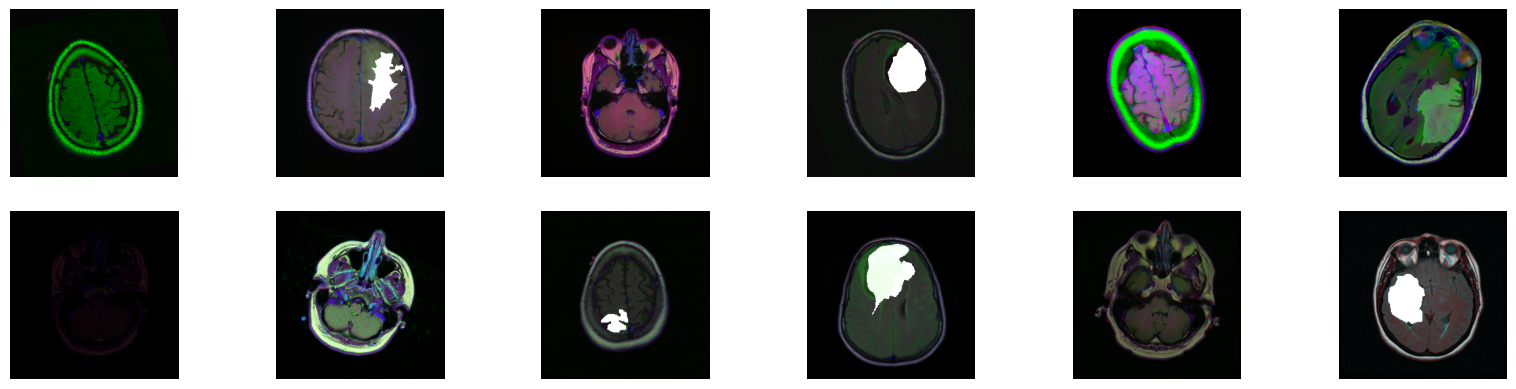

In [387]:
num_images = 12
fig, axs = plt.subplots(nrows=2, ncols=6)
fig.set_figwidth(20)
axs = axs.flatten()

for idx, item_idx in enumerate(torch.randint(train_set.__len__(), (num_images,))):
    img, mask = train_set[item_idx]
    img_with_mask = img + mask

    axs[idx].imshow(img_with_mask.permute(1, 2, 0), cmap="gray")
    axs[idx].axis("off")

## Labels Distribution

1575 956 1.647489539748954


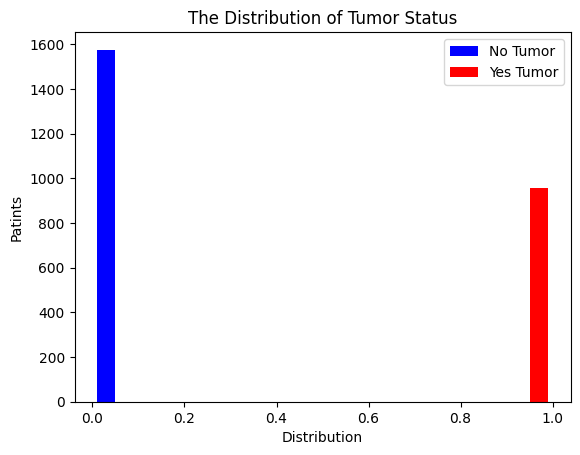

In [327]:
labels = [1 if torch.max(sam[1]) > 0 else 0 for sam in train_set]
no_tumor = list(filter(lambda x: x == 0, labels))
yes_tumor = list(filter(lambda x: x == 1, labels))

plt.hist([no_tumor, yes_tumor], label=["No Tumor", "Yes Tumor"], color=["blue", "red"]);
plt.xlabel("Distribution")
plt.ylabel("Patints")
plt.title("The Distribution of Tumor Status")

print(len(no_tumor), len(yes_tumor), len(no_tumor)/len(yes_tumor))
plt.legend();

## Dice Loss Vision Sample

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.3333334].


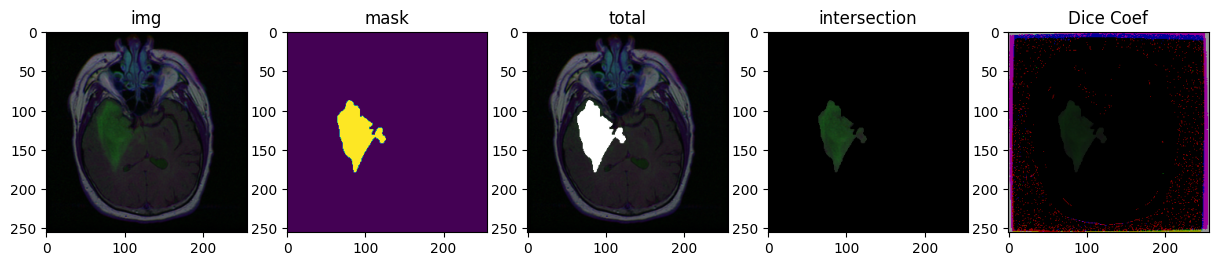

In [338]:
img, mask = train_set[torch.randint(train_set.__len__(), (1,))]

fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(15, 4))
img_ = img.permute(1, 2, 0)
mask_ = mask.permute(1, 2, 0)
smooth = 1e-6
dice_coef = 2.*(img_ * mask_ + smooth) / (img_ + mask_ + smooth)

axs[0].imshow(img_)
axs[1].imshow(mask_)
axs[2].imshow(img_ + mask_)
axs[3].imshow(img_ * mask_);
axs[4].imshow(dice_coef*3e-1)

axs[0].set_title("img")
axs[1].set_title("mask")
axs[2].set_title("total")
axs[3].set_title("intersection")
axs[4].set_title("Dice Coef");

## Make Dataloader

In [339]:
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=32)
test_loader = DataLoader(test_set, batch_size=16)

In [340]:
img, mask = next(iter(train_loader))

img.shape, mask.shape

(torch.Size([32, 3, 256, 256]), torch.Size([32, 1, 256, 256]))

# U-Net Model

## M1

In [ ]:
class UNetModel(nn.Module):
    def __init__(self, unet_size="medium", input_channel=3, num_cls=1):
        super().__init__()

        assert unet_size in ["small", "medium", "large"]
        
        i, j = 0, 0

        if unet_size == "small":
            conv_channels = [input_channel] + [16, 32, 64, 128, 256]
        elif unet_size == "medium":
            conv_channels = [input_channel] + [32, 64, 128, 256, 512]
        else:
            conv_channels = [input_channel] + [64, 128, 256, 512, 1024]
        
        conv_channels_len = len(conv_channels)
        self.conv_ls = nn.ModuleDict()
        self.concat_idx = []
        
        # Encoder
        for channel_idx in range(1, conv_channels_len):
            self.conv_ls[f"conv_{j}"] = self.normal_convolution(conv_channels[channel_idx-1], conv_channels[channel_idx])
            self.conv_ls[f"save_conv_{i}"] = self.normal_convolution(conv_channels[channel_idx], conv_channels[channel_idx])

            # The Stride of the MaxPool must be equal 2 to exactly halve the height and width of the image
            if channel_idx != conv_channels_len-1:
                self.conv_ls[f"max_pool_{i}"] = nn.MaxPool2d(2, 2, 1, return_indices=True)
    
            i += 1
            j += 1

        i = 0
        
        # Decoder
        for channel_idx in range(conv_channels_len-1, 1, -1):
            self.conv_ls[f"up_conv_{i}"] = self.up_convolution(conv_channels[channel_idx], conv_channels[channel_idx-1])
            self.conv_ls[f"max_unpool_{i}"] = nn.MaxUnpool2d(3, 2, 1)
            
            self.conv_ls[f"concat_conv_{i}"] = self.normal_convolution(conv_channels[channel_idx], conv_channels[channel_idx-1])

            # The last layer (Classifier layer)
            if channel_idx == 2:
                self.conv_ls[f"conv_{j}"] = nn.Conv2d(conv_channels[channel_idx-1], num_cls, kernel_size=1)
                continue
            
            self.conv_ls[f"conv_{j}"] = self.normal_convolution(conv_channels[channel_idx-1], conv_channels[channel_idx-1])
            i += 1
            j += 1
            
    def __repr__(self):
        print(self.conv_ls)
        
        return "U-Net()"
    
    def normal_convolution(self, in_channels, out_channels, kernel=3, stride=1, padding=1):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel, stride, padding),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(negative_slope=0.1, inplace=True)
        )
        
    def up_convolution(self, in_channels, out_channels, kernel=3, stride=1, padding=1):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel, stride, padding),
            # nn.BatchNorm2d(out_channels),
            # nn.LeakyReLU(),
        )
    
    def forward(self, y: torch.Tensor):
        concatenation_ls, max_pool_indeces = [], []

        for layer_name in self.conv_ls.keys():
            layer = self.conv_ls[layer_name]
            
            if re.search(r"max_pool_*", layer_name):
                y, indeces = layer(y)
                max_pool_indeces.append(indeces)

            elif re.search(r"max_unpool_*", layer_name):
                concat = concatenation_ls.pop()
                concatenation_ls.append(concat)
                y = layer(y, max_pool_indeces.pop(), output_size=concat.shape)

            elif re.search(r"save_conv_[0-3]$", layer_name):
                y = layer(y)
                concatenation_ls.append(y)
                
            elif re.search(r"concat_conv_*", layer_name):
                concat = concatenation_ls.pop()
                y = torch.concat((concat, y), dim=1)
                y = layer(y)

            else:
                y = layer(y)

        return y

In [ ]:
model = UNetModel()
num_parameters(model)

In [ ]:
model

## M2

In [ ]:
class UNetModel2(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNetModel2, self).__init__()
        
        # Contracting path (encoder)
        self.encoder1 = self.conv_block(in_channels, 64)
        self.encoder2 = self.conv_block(64, 128)
        self.encoder3 = self.conv_block(128, 256)
        self.encoder4 = self.conv_block(256, 512)
        
        # Bottleneck
        self.bottleneck = self.conv_block(512, 1024)
        
        # Expansive path (decoder)
        self.decoder4 = self.upconv_block(1024, 512)
        self.decoder3 = self.upconv_block(512, 256)
        self.decoder2 = self.upconv_block(256, 128)
        self.decoder1 = self.upconv_block(128, 64)

        # Final output layer
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def upconv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoder
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(F.max_pool2d(enc1, kernel_size=2))
        enc3 = self.encoder3(F.max_pool2d(enc2, kernel_size=2))
        enc4 = self.encoder4(F.max_pool2d(enc3, kernel_size=2))

        # Bottleneck
        bottleneck = self.bottleneck(F.max_pool2d(enc4, kernel_size=2))

        # Decoder
        dec4 = self.decoder4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)  # skip connection
        dec4 = self.conv_block(1024, 512)(dec4)  # 512 = 512+512

        dec3 = self.decoder3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)  # skip connection
        dec3 = self.conv_block(512, 256)(dec3)  # 256 = 256+512

        dec2 = self.decoder2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)  # skip connection
        dec2 = self.conv_block(256, 128)(dec2)  # 128 = 128+256

        dec1 = self.decoder1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)  # skip connection
        dec1 = self.conv_block(128, 64)(dec1)  # 64 = 64+128

        return self.final_conv(dec1)

## M3

In [ ]:
class UNetBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int) -> None:
        super(UNetBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=3,
            padding=1
        )
        self.bn1 = nn.BatchNorm2d(num_features=out_channels)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(
            in_channels=out_channels,
            out_channels=out_channels,
            kernel_size=3,
            padding=1
        )
        self.bn2 = nn.BatchNorm2d(num_features=out_channels)
        self.relu2 = nn.ReLU(inplace=True)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        return x

class UNetModel3(nn.Module):
    def __init__(self, in_channels: int = 3, out_channels: int = 1, 
                    n_features: int = 32, depth: int = 5) -> None:
        super(UNetModel3, self).__init__()

        self.layers = []
        self.activations = []
        
        self.layers.append(UNetBlock(in_channels, n_features))
        self.layers[-1].register_forward_hook(self.push_activation())
        self.layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
        
        for _ in range(depth-2):
            self.layers.append(UNetBlock(n_features, n_features))
            self.layers[-1].register_forward_hook(self.push_activation())
            self.layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.layers.append(UNetBlock(n_features, n_features))
        
        for _ in range(depth-1):
            self.layers.append(nn.ConvTranspose2d(
                n_features, n_features, kernel_size=2, stride=2, bias=False
            ))
            self.layers[-1].register_forward_hook(self.pop_activation())
            self.layers.append(UNetBlock(n_features*2, n_features))
            
        self.layers.append(nn.Conv2d(
            in_channels=n_features, out_channels=out_channels, kernel_size=1
        ))
        
        self.layers = nn.Sequential(*self.layers)
    
    def push_activation(self) -> Callable[[torch.nn.Module, torch.Tensor, torch.Tensor], None]:
        def hook(module, input, output):
            self.activations.append(output)
        return hook
    
    def pop_activation(self) -> Callable[[torch.nn.Module, torch.Tensor, torch.Tensor], torch.Tensor]:
        def hook(module, input, output):
            return torch.cat(
                (output, self.activations.pop()),
                dim=1
            )
        return hook

    def forward(self, x):
        x = self.layers(x)
        x = torch.sigmoid(x)
        return x

## M4

In [ ]:
class UNetModel4(nn.Module):
    def __init__(self, in_channel=3, out_channel=1, num_cls=1):
        super(UNetModel4, self).__init__()
        filters = [2**i for i in range(6, 11)]

        # Encoder
        self.conv1 = self._conv_box(in_channel, filters[0]) # 3 => 64 => 64
        self.maxpool1 = nn.MaxPool2d(3, 2, padding=1)
        self.conv2 = self._conv_box(filters[0], filters[1]) # 64 => 128 => 128
        self.maxpool2 = nn.MaxPool2d(3, 2, padding=1)
        self.conv3 = self._conv_box(filters[1], filters[2]) # 128 => 256 => 256
        self.maxpool3 = nn.MaxPool2d(3, 2, padding=1)
        self.conv4 = self._conv_box(filters[2], filters[3]) # 256 => 512 => 512
        self.maxpool4 = nn.MaxPool2d(3, 2, padding=1)

        self.bottleneck = self._conv_box(filters[3], filters[4]) # 512 => 1024 => 1024

        # Decoder
        self.upconv1 = self._upconv_box(filters[4], filters[3]) # 1024 => 512
        self.conv5 = self._conv_box(filters[4], filters[3]) # (512+512) => 512 => 512
        self.upconv2 = self._upconv_box(filters[3], filters[2]) # 512 => 256
        self.conv6 = self._conv_box(filters[3], filters[2]) # (256+256) => 256 => 256
        self.upconv3 = self._upconv_box(filters[2], filters[1]) # 256 => 128
        self.conv7 = self._conv_box(filters[2], filters[1]) # (128+128) => 128 => 128
        self.upconv4 = self._upconv_box(filters[1], filters[0]) # 128 => 64
        self.conv8 = self._conv_box(filters[1], filters[0], double=False) # (64+64) => 64

        # Output layer
        self.output_layer = nn.Conv2d(filters[0], num_cls, 3, padding=1) # 64 => 1

    def _conv_box(self, in_channel, out_channel, double=True):
        layers = nn.ModuleList([
            nn.Conv2d(in_channel, out_channel, 3, padding=1),
            nn.BatchNorm2d(out_channel),
            nn.ReLU(inplace=True)
        ])
        
        if double:
            layers.append(nn.Conv2d(out_channel, out_channel, 3, padding=1))
            layers.append(nn.BatchNorm2d(out_channel))
            layers.append(nn.ReLU(inplace=True))
        
        return nn.Sequential(*layers)

    def _upconv_box(self, in_channel, out_channel):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channel, out_channel, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(out_channel),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        # Encoder
        enc1 = self.conv1(x)
        y = self.maxpool1(enc1)
        enc2 = self.conv2(y)
        y = self.maxpool2(enc2)
        enc3 = self.conv3(y)
        y = self.maxpool3(enc3)
        enc4 = self.conv4(y)
        y = self.maxpool4(enc4)

        y = self.bottleneck(y)

        # Decoder
        y = self.upconv1(y)
        y = torch.concat((enc4, y), dim=1)
        y = self.conv5(y)
        y = self.upconv2(y)
        y = torch.concat((enc3, y), dim=1)
        y = self.conv6(y)
        y = self.upconv3(y)
        y = torch.concat((enc2, y), dim=1)
        y = self.conv7(y)
        y = self.upconv4(y)
        y = torch.concat((enc1, y), dim=1)
        y = self.conv8(y)

        # Output layer
        y = self.output_layer(y)
        
        return y

# Check Paths

## Forward

In [31]:
with torch.no_grad():
    model = UNetModel4().to(device)

    x_batch, y_batch = next(iter(train_loader))
    x_batch, y_batch = x_batch.to(device), y_batch.to(device)
    
    yp = model(x_batch)
    loss = segment_loss_fn(yp, y_batch)

    torch.cuda.empty_cache()

loss.item()

0.8277562856674194

## Backward

In [31]:
mini_percentage = 0.2

_, mini_dataset = random_split(dataset, [1-mini_percentage, mini_percentage])
mini_dataloader = DataLoader(mini_dataset, batch_size=8, shuffle=True)

In [ ]:
model = UNetModel4().to(device)

optimizer = Adam(model.parameters(), lr=1e-04)

for ep in range(3):
    model, _ = train_one_epoch(model, mini_dataloader, optimizer, segment_loss_fn, avg_fn, ep, device)
    validate_one_epoch(model, mini_dataloader, segment_loss_fn, avg_fn, device)
    
torch.cuda.empty_cache()

# Find Efficient Hyper-Parameters

In [30]:
start_time = datetime.now().replace(microsecond=0)
l = [10**(-i) for i in range(6, 3, -1)]

for lr in l:
    model = UNetModel4().to(device)
    optimizer = Adam(model.parameters(), lr=lr)
    
    print(f"\nlr: {lr}")
    for ep in range(8):
        model, _ = train_one_epoch(model, train_loader, optimizer, weighted_dice_loss, avg_fn, ep, device)
        validate_one_epoch(model, valid_loader, weighted_dice_loss, avg_fn, device)
        
    torch.cuda.empty_cache()

end_time = datetime.now().replace(microsecond=0)

print(f"\nRun Time: {end_time-start_time}")


lr: 1e-06


Epoch 0: 100%|██████████| 172/172 [01:50<00:00,  1.56 batch/s, Dice_loss=1.83]


Valid => Dice_loss: 1.81                               


Epoch 1: 100%|██████████| 172/172 [01:50<00:00,  1.56 batch/s, Dice_loss=1.81]


Valid => Dice_loss: 1.8                                


Epoch 2: 100%|██████████| 172/172 [01:49<00:00,  1.57 batch/s, Dice_loss=1.79]


Valid => Dice_loss: 1.78                               


Epoch 3: 100%|██████████| 172/172 [01:50<00:00,  1.56 batch/s, Dice_loss=1.78]


Valid => Dice_loss: 1.77                               


Epoch 4: 100%|██████████| 172/172 [01:49<00:00,  1.57 batch/s, Dice_loss=1.77]


Valid => Dice_loss: 1.74                               


Epoch 5: 100%|██████████| 172/172 [01:51<00:00,  1.54 batch/s, Dice_loss=1.75]


Valid => Dice_loss: 1.73                               


Epoch 6: 100%|██████████| 172/172 [01:52<00:00,  1.53 batch/s, Dice_loss=1.72]


Valid => Dice_loss: 1.71                               


Epoch 7: 100%|██████████| 172/172 [01:51<00:00,  1.54 batch/s, Dice_loss=1.71]


Valid => Dice_loss: 1.69                               

lr: 1e-05


Epoch 0: 100%|██████████| 172/172 [01:53<00:00,  1.51 batch/s, Dice_loss=1.79]


Valid => Dice_loss: 1.76                               


Epoch 1: 100%|██████████| 172/172 [01:50<00:00,  1.56 batch/s, Dice_loss=1.7] 


Valid => Dice_loss: 1.67                               


Epoch 2: 100%|██████████| 172/172 [01:51<00:00,  1.55 batch/s, Dice_loss=1.63]


Valid => Dice_loss: 1.56                               


Epoch 3: 100%|██████████| 172/172 [01:51<00:00,  1.55 batch/s, Dice_loss=1.58]


Valid => Dice_loss: 1.53                               


Epoch 4: 100%|██████████| 172/172 [01:49<00:00,  1.57 batch/s, Dice_loss=1.54]


Valid => Dice_loss: 1.49                               


Epoch 5: 100%|██████████| 172/172 [01:50<00:00,  1.55 batch/s, Dice_loss=1.52]


Valid => Dice_loss: 1.47                               


Epoch 6: 100%|██████████| 172/172 [01:48<00:00,  1.59 batch/s, Dice_loss=1.49]


Valid => Dice_loss: 1.42                               


Epoch 7: 100%|██████████| 172/172 [01:49<00:00,  1.57 batch/s, Dice_loss=1.47]


Valid => Dice_loss: 1.45                               

lr: 0.0001


Epoch 0: 100%|██████████| 172/172 [01:48<00:00,  1.58 batch/s, Dice_loss=1.67]


Valid => Dice_loss: 1.56                               


Epoch 1: 100%|██████████| 172/172 [01:52<00:00,  1.53 batch/s, Dice_loss=1.51]


Valid => Dice_loss: 1.48                               


Epoch 2: 100%|██████████| 172/172 [01:48<00:00,  1.58 batch/s, Dice_loss=1.46]


Valid => Dice_loss: 1.43                               


Epoch 3: 100%|██████████| 172/172 [01:49<00:00,  1.57 batch/s, Dice_loss=1.44]


Valid => Dice_loss: 1.41                               


Epoch 4: 100%|██████████| 172/172 [01:49<00:00,  1.57 batch/s, Dice_loss=1.43]


Valid => Dice_loss: 1.4                                


Epoch 5: 100%|██████████| 172/172 [01:51<00:00,  1.54 batch/s, Dice_loss=1.42]


Valid => Dice_loss: 1.36                               


Epoch 6: 100%|██████████| 172/172 [01:49<00:00,  1.57 batch/s, Dice_loss=1.39]


Valid => Dice_loss: 1.38                               


Epoch 7: 100%|██████████| 172/172 [01:49<00:00,  1.57 batch/s, Dice_loss=1.38]


Valid => Dice_loss: 1.36                               

lr: 0.001


Epoch 0: 100%|██████████| 172/172 [01:49<00:00,  1.57 batch/s, Dice_loss=1.58]


Valid => Dice_loss: 1.49                               


Epoch 1: 100%|██████████| 172/172 [01:48<00:00,  1.59 batch/s, Dice_loss=1.53]


Valid => Dice_loss: 1.47                               


Epoch 2: 100%|██████████| 172/172 [01:49<00:00,  1.57 batch/s, Dice_loss=1.48]


Valid => Dice_loss: 1.43                               


Epoch 3: 100%|██████████| 172/172 [01:49<00:00,  1.57 batch/s, Dice_loss=1.46]


Valid => Dice_loss: 1.43                               


Epoch 4: 100%|██████████| 172/172 [01:47<00:00,  1.60 batch/s, Dice_loss=1.45]


Valid => Dice_loss: 1.49                               


Epoch 5:  70%|███████   | 121/172 [01:16<00:32,  1.58 batch/s, Dice_loss=1.44]


KeyboardInterrupt: 

# Full Train

In [30]:
model = UNetModel("small").to(device)
# model = UNetModel2(3, 1).to(device)
# model = UNetModel4().to(device)

best_valid_loss = torch.inf
final_model = None

num_parameters(model)

'Number of Parameters: 2,159,297'

In [31]:
epochs = 100

optimizer = Adam(model.parameters(), lr=1e-2)

# scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[5, 40], gamma=0.1)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, eta_min=1e-6, T_max=epochs)

In [32]:
train_loss_hist, valid_loss_hist = [], []

In [33]:
start_time = datetime.now().replace(microsecond=0)

for ep in range(epochs):
    model, train_loss = train_one_epoch(model, train_loader, optimizer, segment_loss_fn, avg_fn, ep, device)
    valid_loss = validate_one_epoch(model, valid_loader, segment_loss_fn, avg_fn, device)
    scheduler.step()

    if best_valid_loss > valid_loss:
        final_model = model
        best_valid_loss = valid_loss

    train_loss_hist.append(train_loss)
    valid_loss_hist.append(valid_loss)

torch.cuda.empty_cache()

end_time = datetime.now().replace(microsecond=0)

print(f"\nRun Time: {end_time-start_time}")

Epoch 0: 100%|█████████████████████████████████████████████████████████████████████| 61/61 [01:21<00:00,  1.34s/ batch, Dice_loss=0.768]


Valid => Dice_loss: 0.838                              


Epoch 1: 100%|█████████████████████████████████████████████████████████████████████| 61/61 [01:21<00:00,  1.33s/ batch, Dice_loss=0.429]


Valid => Dice_loss: 0.417                              


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████| 61/61 [01:21<00:00,  1.33s/ batch, Dice_loss=0.346]


Valid => Dice_loss: 0.37                               


Epoch 3: 100%|██████████████████████████████████████████████████████████████████████| 61/61 [01:21<00:00,  1.33s/ batch, Dice_loss=0.32]


Valid => Dice_loss: 0.66                               


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████| 61/61 [01:21<00:00,  1.33s/ batch, Dice_loss=0.298]


Valid => Dice_loss: 0.282                              


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████| 61/61 [01:21<00:00,  1.33s/ batch, Dice_loss=0.301]


Valid => Dice_loss: 0.346                              


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████| 61/61 [01:21<00:00,  1.33s/ batch, Dice_loss=0.283]


Valid => Dice_loss: 0.301                              


Epoch 7: 100%|█████████████████████████████████████████████████████████████████████| 61/61 [01:21<00:00,  1.33s/ batch, Dice_loss=0.279]


Valid => Dice_loss: 0.264                              


Epoch 8: 100%|█████████████████████████████████████████████████████████████████████| 61/61 [01:21<00:00,  1.33s/ batch, Dice_loss=0.263]


Valid => Dice_loss: 0.252                              


Epoch 9: 100%|█████████████████████████████████████████████████████████████████████| 61/61 [01:21<00:00,  1.33s/ batch, Dice_loss=0.254]


Valid => Dice_loss: 0.306                              


Epoch 10: 100%|████████████████████████████████████████████████████████████████████| 61/61 [01:21<00:00,  1.33s/ batch, Dice_loss=0.244]


Valid => Dice_loss: 0.242                              


Epoch 11: 100%|████████████████████████████████████████████████████████████████████| 61/61 [01:21<00:00,  1.33s/ batch, Dice_loss=0.269]


Valid => Dice_loss: 0.477                              


Epoch 12: 100%|████████████████████████████████████████████████████████████████████| 61/61 [01:21<00:00,  1.33s/ batch, Dice_loss=0.246]


Valid => Dice_loss: 0.237                              


Epoch 13: 100%|████████████████████████████████████████████████████████████████████| 61/61 [01:21<00:00,  1.33s/ batch, Dice_loss=0.226]


Valid => Dice_loss: 0.22                               


Epoch 14: 100%|████████████████████████████████████████████████████████████████████| 61/61 [01:21<00:00,  1.33s/ batch, Dice_loss=0.237]


Valid => Dice_loss: 0.242                              


Epoch 15: 100%|█████████████████████████████████████████████████████████████████████| 61/61 [01:21<00:00,  1.33s/ batch, Dice_loss=0.23]


Valid => Dice_loss: 0.379                              


Epoch 16: 100%|████████████████████████████████████████████████████████████████████| 61/61 [01:21<00:00,  1.33s/ batch, Dice_loss=0.219]


Valid => Dice_loss: 0.371                              


Epoch 17: 100%|████████████████████████████████████████████████████████████████████| 61/61 [01:21<00:00,  1.33s/ batch, Dice_loss=0.204]


Valid => Dice_loss: 0.212                              


Epoch 18: 100%|████████████████████████████████████████████████████████████████████| 61/61 [01:21<00:00,  1.33s/ batch, Dice_loss=0.198]


Valid => Dice_loss: 0.199                              


Epoch 19: 100%|████████████████████████████████████████████████████████████████████| 61/61 [01:21<00:00,  1.33s/ batch, Dice_loss=0.225]


Valid => Dice_loss: 0.217                              


Epoch 20: 100%|████████████████████████████████████████████████████████████████████| 61/61 [01:21<00:00,  1.33s/ batch, Dice_loss=0.197]


Valid => Dice_loss: 0.208                              


Epoch 21: 100%|████████████████████████████████████████████████████████████████████| 61/61 [01:21<00:00,  1.33s/ batch, Dice_loss=0.198]


Valid => Dice_loss: 0.194                              


Epoch 22: 100%|████████████████████████████████████████████████████████████████████| 61/61 [01:21<00:00,  1.33s/ batch, Dice_loss=0.189]


Valid => Dice_loss: 0.198                              


Epoch 23: 100%|████████████████████████████████████████████████████████████████████| 61/61 [01:21<00:00,  1.33s/ batch, Dice_loss=0.183]


Valid => Dice_loss: 0.201                              


Epoch 24: 100%|████████████████████████████████████████████████████████████████████| 61/61 [01:21<00:00,  1.33s/ batch, Dice_loss=0.185]


Valid => Dice_loss: 0.194                              


Epoch 25: 100%|████████████████████████████████████████████████████████████████████| 61/61 [01:21<00:00,  1.33s/ batch, Dice_loss=0.196]


Valid => Dice_loss: 0.242                              


Epoch 26: 100%|████████████████████████████████████████████████████████████████████| 61/61 [01:21<00:00,  1.33s/ batch, Dice_loss=0.219]


Valid => Dice_loss: 0.209                              


Epoch 27: 100%|████████████████████████████████████████████████████████████████████| 61/61 [01:21<00:00,  1.33s/ batch, Dice_loss=0.178]


Valid => Dice_loss: 0.205                              


Epoch 28: 100%|████████████████████████████████████████████████████████████████████| 61/61 [01:21<00:00,  1.33s/ batch, Dice_loss=0.212]


Valid => Dice_loss: 0.203                              


Epoch 29: 100%|████████████████████████████████████████████████████████████████████| 61/61 [01:21<00:00,  1.33s/ batch, Dice_loss=0.185]


Valid => Dice_loss: 0.253                              


Epoch 30: 100%|████████████████████████████████████████████████████████████████████| 61/61 [01:21<00:00,  1.33s/ batch, Dice_loss=0.208]


Valid => Dice_loss: 0.209                              


Epoch 31: 100%|████████████████████████████████████████████████████████████████████| 61/61 [01:21<00:00,  1.33s/ batch, Dice_loss=0.179]


Valid => Dice_loss: 0.243                              


Epoch 32: 100%|████████████████████████████████████████████████████████████████████| 61/61 [01:21<00:00,  1.33s/ batch, Dice_loss=0.197]


Valid => Dice_loss: 0.229                              


Epoch 33: 100%|████████████████████████████████████████████████████████████████████| 61/61 [01:21<00:00,  1.33s/ batch, Dice_loss=0.166]


Valid => Dice_loss: 0.179                              


Epoch 34: 100%|████████████████████████████████████████████████████████████████████| 61/61 [01:21<00:00,  1.33s/ batch, Dice_loss=0.163]


Valid => Dice_loss: 0.161                              


Epoch 35: 100%|████████████████████████████████████████████████████████████████████| 61/61 [01:21<00:00,  1.33s/ batch, Dice_loss=0.171]


Valid => Dice_loss: 0.158                              


Epoch 36: 100%|████████████████████████████████████████████████████████████████████| 61/61 [01:21<00:00,  1.33s/ batch, Dice_loss=0.157]


Valid => Dice_loss: 0.161                              


Epoch 37: 100%|████████████████████████████████████████████████████████████████████| 61/61 [01:21<00:00,  1.34s/ batch, Dice_loss=0.157]


Valid => Dice_loss: 0.187                              


Epoch 38: 100%|████████████████████████████████████████████████████████████████████| 61/61 [01:21<00:00,  1.33s/ batch, Dice_loss=0.156]


Valid => Dice_loss: 0.171                              


Epoch 39: 100%|████████████████████████████████████████████████████████████████████| 61/61 [01:21<00:00,  1.33s/ batch, Dice_loss=0.146]


Valid => Dice_loss: 0.161                              


Epoch 40: 100%|████████████████████████████████████████████████████████████████████| 61/61 [01:21<00:00,  1.33s/ batch, Dice_loss=0.152]


Valid => Dice_loss: 0.16                               


Epoch 41: 100%|████████████████████████████████████████████████████████████████████| 61/61 [01:21<00:00,  1.33s/ batch, Dice_loss=0.156]


Valid => Dice_loss: 0.146                              


Epoch 42: 100%|█████████████████████████████████████████████████████████████████████| 61/61 [01:21<00:00,  1.33s/ batch, Dice_loss=0.15]


Valid => Dice_loss: 0.156                              


Epoch 43: 100%|████████████████████████████████████████████████████████████████████| 61/61 [01:21<00:00,  1.33s/ batch, Dice_loss=0.155]


Valid => Dice_loss: 0.142                              


Epoch 44: 100%|████████████████████████████████████████████████████████████████████| 61/61 [01:21<00:00,  1.33s/ batch, Dice_loss=0.146]


Valid => Dice_loss: 0.145                              


Epoch 45: 100%|████████████████████████████████████████████████████████████████████| 61/61 [01:21<00:00,  1.33s/ batch, Dice_loss=0.146]


Valid => Dice_loss: 0.15                               


Epoch 46: 100%|████████████████████████████████████████████████████████████████████| 61/61 [01:21<00:00,  1.33s/ batch, Dice_loss=0.145]


Valid => Dice_loss: 0.15                               


Epoch 47: 100%|████████████████████████████████████████████████████████████████████| 61/61 [01:21<00:00,  1.33s/ batch, Dice_loss=0.132]


Valid => Dice_loss: 0.136                              


Epoch 48: 100%|████████████████████████████████████████████████████████████████████| 61/61 [01:21<00:00,  1.33s/ batch, Dice_loss=0.128]


Valid => Dice_loss: 0.16                               


Epoch 49: 100%|████████████████████████████████████████████████████████████████████| 61/61 [01:21<00:00,  1.33s/ batch, Dice_loss=0.135]


Valid => Dice_loss: 0.152                              


Epoch 50: 100%|████████████████████████████████████████████████████████████████████| 61/61 [01:21<00:00,  1.33s/ batch, Dice_loss=0.138]


Valid => Dice_loss: 0.139                              


Epoch 51: 100%|████████████████████████████████████████████████████████████████████| 61/61 [01:21<00:00,  1.33s/ batch, Dice_loss=0.172]


Valid => Dice_loss: 0.183                              


Epoch 52: 100%|████████████████████████████████████████████████████████████████████| 61/61 [01:21<00:00,  1.33s/ batch, Dice_loss=0.169]


Valid => Dice_loss: 0.183                              


Epoch 53: 100%|████████████████████████████████████████████████████████████████████| 61/61 [01:21<00:00,  1.33s/ batch, Dice_loss=0.152]


Valid => Dice_loss: 0.144                              


Epoch 54: 100%|████████████████████████████████████████████████████████████████████| 61/61 [01:21<00:00,  1.33s/ batch, Dice_loss=0.131]


Valid => Dice_loss: 0.163                              


Epoch 55: 100%|████████████████████████████████████████████████████████████████████| 61/61 [01:21<00:00,  1.33s/ batch, Dice_loss=0.129]


Valid => Dice_loss: 0.139                              


Epoch 56: 100%|████████████████████████████████████████████████████████████████████| 61/61 [01:21<00:00,  1.33s/ batch, Dice_loss=0.127]


Valid => Dice_loss: 0.135                              


Epoch 57: 100%|████████████████████████████████████████████████████████████████████| 61/61 [01:21<00:00,  1.33s/ batch, Dice_loss=0.122]


Valid => Dice_loss: 0.136                              


Epoch 58: 100%|████████████████████████████████████████████████████████████████████| 61/61 [01:21<00:00,  1.33s/ batch, Dice_loss=0.129]


Valid => Dice_loss: 0.142                              


Epoch 59: 100%|████████████████████████████████████████████████████████████████████| 61/61 [01:21<00:00,  1.33s/ batch, Dice_loss=0.186]


Valid => Dice_loss: 0.189                              


Epoch 60: 100%|████████████████████████████████████████████████████████████████████| 61/61 [01:21<00:00,  1.33s/ batch, Dice_loss=0.141]


Valid => Dice_loss: 0.146                              


Epoch 61: 100%|████████████████████████████████████████████████████████████████████| 61/61 [01:21<00:00,  1.33s/ batch, Dice_loss=0.146]


Valid => Dice_loss: 0.135                              


Epoch 62: 100%|████████████████████████████████████████████████████████████████████| 61/61 [01:21<00:00,  1.33s/ batch, Dice_loss=0.132]


Valid => Dice_loss: 0.152                              


Epoch 63: 100%|████████████████████████████████████████████████████████████████████| 61/61 [01:21<00:00,  1.33s/ batch, Dice_loss=0.157]


Valid => Dice_loss: 0.148                              


Epoch 64: 100%|████████████████████████████████████████████████████████████████████| 61/61 [01:21<00:00,  1.33s/ batch, Dice_loss=0.142]


Valid => Dice_loss: 0.142                              


Epoch 65: 100%|████████████████████████████████████████████████████████████████████| 61/61 [01:21<00:00,  1.33s/ batch, Dice_loss=0.121]


Valid => Dice_loss: 0.136                              


Epoch 66: 100%|████████████████████████████████████████████████████████████████████| 61/61 [01:21<00:00,  1.33s/ batch, Dice_loss=0.123]


Valid => Dice_loss: 0.132                              


Epoch 67: 100%|████████████████████████████████████████████████████████████████████| 61/61 [01:21<00:00,  1.33s/ batch, Dice_loss=0.123]


Valid => Dice_loss: 0.135                              


Epoch 68: 100%|████████████████████████████████████████████████████████████████████| 61/61 [01:21<00:00,  1.33s/ batch, Dice_loss=0.112]


Valid => Dice_loss: 0.135                              


Epoch 69:  90%|█████████████████████████████████████████████████████████████▎      | 55/61 [01:15<00:08,  1.38s/ batch, Dice_loss=0.112]


KeyboardInterrupt: 

# Learning Curve

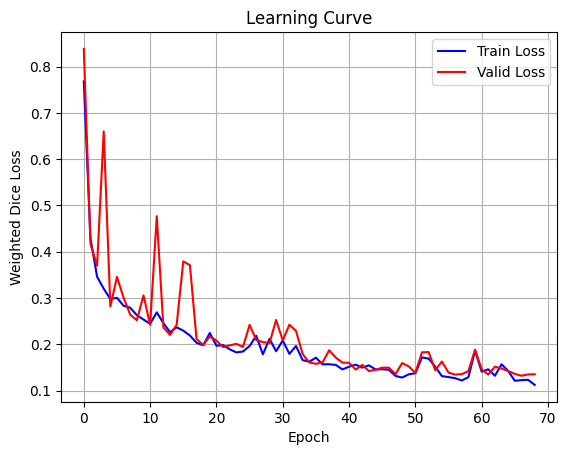

In [34]:
plot_histories(train_loss_hist, [], valid_loss_hist, []);

# Save the Trained Model

In [39]:
torch.save(final_model, "./final_model.pt")

# Testing Phase

In [40]:
final_model_loaded = torch.load("final_model.pt", weights_only=False).to(device)
num_parameters(final_model_loaded)

'Number of Parameters: 2,159,297'

In [41]:
start_time = datetime.now().replace(microsecond=0)

with torch.inference_mode():
    # test_loss = validate_one_epoch(final_model_loaded, test_loader, segment_loss_fn, avg_fn, device)
    test_loss = validate_one_epoch(final_model_loaded, test_loader, weighted_dice_loss, avg_fn, device)
    
    torch.cuda.empty_cache()

end_time = datetime.now().replace(microsecond=0)

print(f"\nRun Time: {end_time-start_time}")

Valid => Dice_loss: 0.445                              

Run Time: 0:00:04


In [42]:
test_iter = iter(test_loader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..4.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..4.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..4.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..4.0].


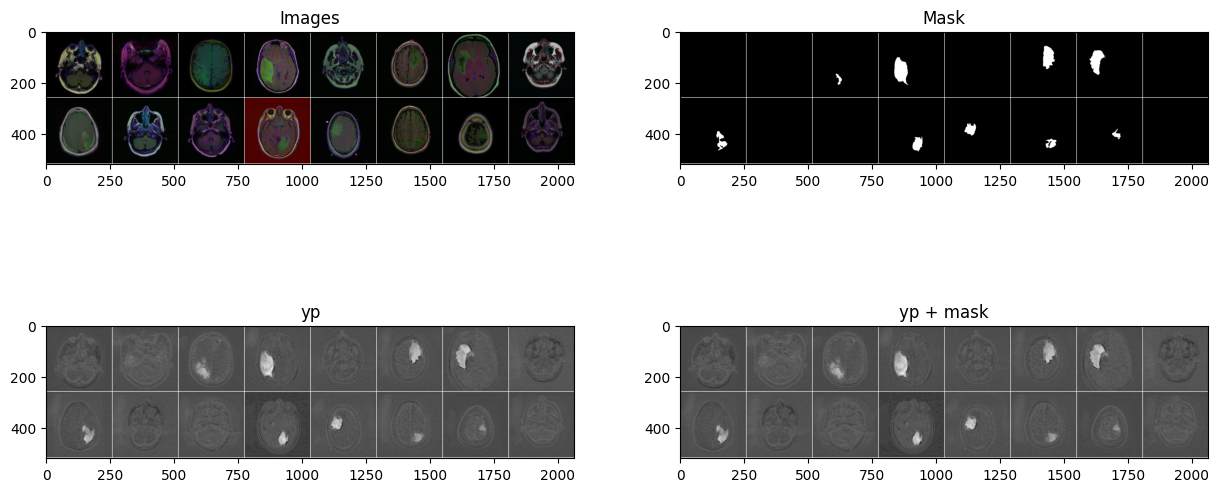

In [46]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 7))

with torch.inference_mode():
    img, mask = next(test_iter)
    img = img.to(device)
    
    yp = final_model_loaded(img)

    torch.cuda.empty_cache()

yp = yp.to("cpu")
img = img.to("cpu")

grid_img = make_grid(img, nrow=8, pad_value=4, normalize=True).permute(1, 2, 0)
grid_mask = make_grid(mask, nrow=8, pad_value=4, normalize=True).permute(1, 2, 0)
grid_yp = make_grid(yp, nrow=8, pad_value=4, normalize=True).permute(1, 2, 0)
grid_mix = make_grid(yp+mask, nrow=8, pad_value=4, normalize=True).permute(1, 2, 0)

axs[0][0].imshow(grid_img)
axs[0][0].set_title("Images")

axs[0][1].imshow(grid_mask)
axs[0][1].set_title("Mask")

axs[1][0].imshow(grid_yp)
axs[1][0].set_title("yp")

axs[1][1].imshow(grid_mix)
axs[1][1].set_title("yp + mask");

# Check Weights

In [35]:
layers = []
for n in final_model_loaded.named_parameters():
    if re.search("up_conv_[0-9].[0-9].weight$", n[0]) or re.search("conv_ls.conv_[0-9].[0-9].weight$", n[0]):
        new_name = n[0].replace("conv_ls.", "")
        new_name = new_name.replace(".weight", "")
        layers.append((new_name, n[1]))

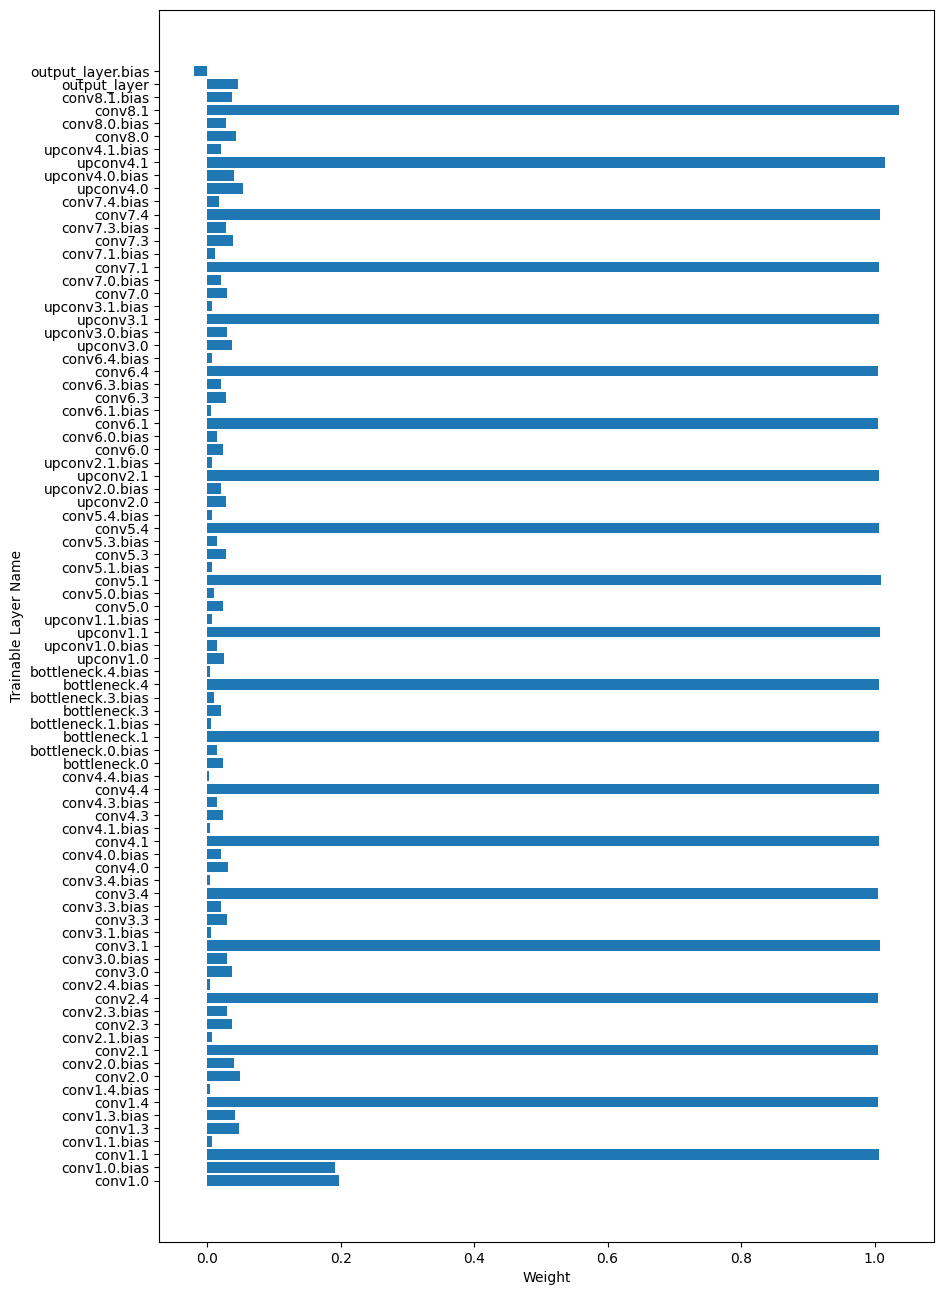

In [36]:
num_parameters(final_model_loaded)

grads = []
names = []

# for w in layers:
#     grads.append(torch.max(w[1]).item())
#     names.append(w[0])

for w in final_model_loaded.named_parameters():
    grads.append(torch.max(w[1]).item())
    
    new_name = w[0].replace("conv_ls.", "")
    new_name = new_name.replace(".weight", "")
    names.append(new_name)
    
plt.figure(figsize=(10, 16))
plt.barh(names, grads)
plt.xlabel("Weight");
plt.ylabel("Trainable Layer Name");